##Instalación de librerias

In [33]:
# Instalación silenciosa de librerías
!pip install -q pandas
!pip install -q numpy
!pip install -q scipy
!pip install -q matplotlib
!pip install -q seaborn
!pip install -q plotly
!pip install -q yellowbrick
!pip install -q scikit-learn
!pip install -q imbalanced-learn
!pip install -q tqdm
!pip install -q joblib
!pip install -q huggingface_hub
!pip install -q datasets
!pip install -q fsspec==2024.10.0


##Cargar base de datos

In [34]:
# Importamos las librerías necesarias
import pandas as pd
from datasets import load_dataset
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Cargamos el dataset y lo mezclamos
dataset = load_dataset("13nishit/LoanApprovalPrediction")
print(dataset)

dataset = load_dataset("13nishit/LoanApprovalPrediction", streaming=True)
df = pd.DataFrame(list(dataset['train'].shuffle(seed=42).take(130)))


DatasetDict({
    train: Dataset({
        features: ['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
        num_rows: 614
    })
})


##Procesamiento de datos


=== Información del DataFrame ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            130 non-null    object 
 1   Gender             130 non-null    object 
 2   Married            130 non-null    object 
 3   Dependents         127 non-null    object 
 4   Education          130 non-null    object 
 5   Self_Employed      120 non-null    object 
 6   ApplicantIncome    130 non-null    int64  
 7   CoapplicantIncome  130 non-null    float64
 8   LoanAmount         126 non-null    float64
 9   Loan_Amount_Term   125 non-null    float64
 10  Credit_History     116 non-null    float64
 11  Property_Area      130 non-null    object 
 12  Loan_Status        130 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 13.3+ KB
None

=== Valores únicos por columna ===

Loan_ID:
Tipo de dato: object
Valor

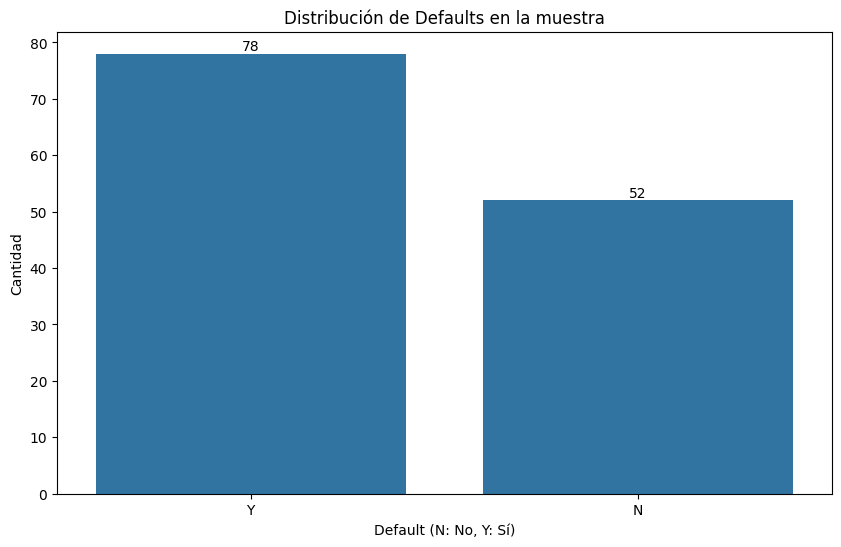

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001280,Male,Yes,2,Not Graduate,No,3333,2000.0,99.0,360.0,NaN,Semiurban,Y
1,LP001345,Male,Yes,2,Not Graduate,No,4288,3263.0,133.0,180.0,1.0,Urban,Y
2,LP001633,Male,Yes,1,Graduate,No,6400,7250.0,180.0,360.0,0.0,Urban,N
3,LP002693,Male,Yes,2,Graduate,Yes,7948,7166.0,480.0,360.0,1.0,Rural,Y
4,LP002315,Male,Yes,1,Graduate,No,8300,0.0,152.0,300.0,0.0,Semiurban,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,LP001259,Male,Yes,1,Graduate,Yes,1000,3022.0,110.0,360.0,1.0,Urban,N
126,LP002517,Male,Yes,1,Not Graduate,No,2653,1500.0,113.0,180.0,0.0,Rural,N
127,LP002357,Female,No,0,Not Graduate,No,2720,0.0,80.0,NaN,0.0,Urban,N
128,LP001478,Male,No,0,Graduate,No,2718,0.0,70.0,360.0,1.0,Semiurban,Y


In [35]:
# 1. Examinamos la información básica del DataFrame
print("\n=== Información del DataFrame ===")
print(df.info())

# 2. Verificamos los tipos de datos y valores únicos para cada columna
print("\n=== Valores únicos por columna ===")
for column in df.columns:
    print(f"\n{column}:")
    print(f"Tipo de dato: {df[column].dtype}")
    print(f"Valores únicos: {df[column].nunique()}")

# Filtrar valores nulos antes de ordenar
    unique_values = [val for val in df[column].unique() if pd.notna(val)]

    # Ordenar solo si hay valores no nulos
    if unique_values:
        print(f"Primeros valores únicos: {sorted(unique_values)[:5]}")
    else:
        print("Primeros valores únicos: No hay valores válidos")

# 3. Verificamos valores nulos
print("\n=== Valores nulos ===")
print(df.isnull().sum())

# 4. Estadísticas descriptivas básicas
print("\n=== Estadísticas descriptivas ===")
print(df.describe())

# 5. Debalance de clases

print("📊 Distribución de la variable objetivo (Loan_Status):")
class_dist = df['Loan_Status'].value_counts(normalize=True)
print("\nPorcentajes:")
for clase, porcentaje in class_dist.items():
    print(f"Clase {clase}: {porcentaje*100:.2f}%")

# Visualizamos la distribución con un gráfico de barras
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Loan_Status')
plt.title('Distribución de Defaults en la muestra')
plt.xlabel('Default (N: No, Y: Sí)')
plt.ylabel('Cantidad')

# Añadimos los valores exactos sobre cada barra
for i in plt.gca().containers[0]:
    plt.text(i.get_x() + i.get_width()/2,
            i.get_height(),
            f'{int(i.get_height())}',
            ha='center', va='bottom')

plt.show()

df

In [89]:
def preprocess_data(df):
    """
    Realiza el preprocesamiento completo de los datos.
    """
    # 1. Separar features
    numeric_features, categorical_features = categorize_features(df)

    # 2. Limpiar datos categóricos
    df = clean_categorical_data(df)

    # 3. Reemplazar "3+" por "3" en Dependents y convertir a numérico
    df['Dependents'] = df['Dependents'].replace('3+', '3').astype(float)

    # 4. Estandarizar variables numéricas
    scaler = StandardScaler()
    df[numeric_features] = scaler.fit_transform(df[numeric_features])

    # 5. Codificar variable objetivo Loan_Status (Y -> 1, N -> 0)
    df['Loan_Status'] = df['Loan_Status'].map({'Y': 1, 'N': 0})

    # 6. Codificar otras Variables
    df['Married'] = df['Married'].map({'Yes': 1, 'No': 0})
    df['Education'] = df['Education'].map({'Graduate': 1, 'Not Graduate': 0})
    df['Self_Employed'] = df['Self_Employed'].map({'Yes': 1, 'No': 0})

    # 7. Crear dummies para Property_Area
    df = pd.get_dummies(df, columns=['Property_Area'], prefix='', prefix_sep='')
    # Convertir solo las columnas dummy a int. Rellenar NaNs con 0 en columnas numéricas.
    for col in ['Rural', 'Semiurban', 'Urban']:
        df[col] = df[col].fillna(0).astype(int)

    # 8. Crear dummies para Gender
    df = pd.get_dummies(df, columns=['Gender'], prefix='', prefix_sep='')
    # Convertir solo las columnas dummy a int. Rellenar NaNs con 0 en columnas numéricas.
    for col in ['Female', 'Male']:
        df[col] = df[col].fillna(0).astype(int)

    # 9. Revisar si Loan_ID
    print("Valores únicos en Loan_ID:", df['Loan_ID'].nunique())
    print("Número de filas:", len(df))
    # Al ser valores unicos se puedes eliminar
    # Guardar los IDs (opcional)
    loan_ids = df['Loan_ID']
    # Eliminar la columna de ID
    df = df.drop(columns=['Loan_ID'])
    # Verificar que la columna se eliminó
    print("Columnas después de eliminar Loan_ID:", df.columns)

    # 10. Imputación de valores nulos
    # Imputación con la moda para columnas categóricas
    imputer_median = SimpleImputer(missing_values=np.nan, strategy='median')
    columns_median = ['Married', 'Self_Employed', 'Dependents', 'Credit_History']
    df[columns_median] = imputer_median.fit_transform(df[columns_median])

    # Imputación con la media para columnas numéricas
    imputer_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
    columns_mean = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']
    df[columns_mean] = imputer_mean.fit_transform(df[columns_mean])

    # 11. Verificar que no queden valores nulos
    print("\nValores nulos después de la imputación:")
    print(df.isnull().sum())

    #12. Eliminamos Valores nulos para Loan_Amount_Term
    df = df.dropna(subset=['Loan_Amount_Term'])

    # Verificar que las filas se han eliminado
    print("Número de filas después de eliminar valores nulos en 'Loan_Amount_Term':", len(df))
    print("\nValores nulos después de la eliminación:")
    print(df.isnull().sum())

    # 13. Separar features y target
    X = df.drop('Loan_Status', axis=1)
    y = df['Loan_Status']

    # 14. Guardar información del preprocesamiento
    preprocessing_info = {
        'numeric_features': numeric_features,
        'categorical_features': categorical_features,
        'scaler': scaler,
        'imputer_mode': imputer_median,
        'imputer_mean': imputer_mean
    }

    return X, y, preprocessing_info


In [90]:
# Ejecutar el Preprocesamiento

# Importar y cargar datos
from datasets import load_dataset
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd


# 1. Cargar datos
dataset = load_dataset("13nishit/LoanApprovalPrediction", streaming=True)
df = pd.DataFrame(list(dataset['train'].shuffle(seed=42)))

# 2. Aplicar preprocesamiento
X, y, preprocessing_info = preprocess_data(df)

# 3. Imprimir resumen
print_preprocessing_summary(X, y)

# 4. Verificar las características procesadas
print("\n=== Características procesadas ===")
print("\nCaracterísticas numéricas:")
print(preprocessing_info['numeric_features'])
print("\nCaracterísticas categóricas:")
print(preprocessing_info['categorical_features'])

# 5. Mostrar información adicional sobre los datos procesados
print("\n=== Información adicional ===")
print(f"Número total de características: {X.shape[1]}")
print(f"Número total de observaciones: {X.shape[0]}")
print("\nPrimeras columnas del dataset procesado:")
print(X.head())




Valores únicos en Loan_ID: 614
Número de filas: 614
Columnas después de eliminar Loan_ID: Index(['Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Loan_Status', 'Rural',
       'Semiurban', 'Urban', 'Female', 'Male'],
      dtype='object')

Valores nulos después de la imputación:
Married               0
Dependents            0
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            0
Loan_Amount_Term     14
Credit_History        0
Loan_Status           0
Rural                 0
Semiurban             0
Urban                 0
Female                0
Male                  0
dtype: int64
Número de filas después de eliminar valores nulos en 'Loan_Amount_Term': 600

Valores nulos después de la eliminación:
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0


##Con los datos de ellos

README.md:   0%|          | 0.00/2.64k [00:00<?, ?B/s]


=== Información del DataFrame ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          10000 non-null  int64  
 1   LIMIT_BAL                   10000 non-null  float64
 2   SEX                         10000 non-null  int64  
 3   EDUCATION                   10000 non-null  int64  
 4   MARRIAGE                    10000 non-null  int64  
 5   AGE                         10000 non-null  int64  
 6   PAY_0                       10000 non-null  int64  
 7   PAY_2                       10000 non-null  int64  
 8   PAY_3                       10000 non-null  int64  
 9   PAY_4                       10000 non-null  int64  
 10  PAY_5                       10000 non-null  int64  
 11  PAY_6                       10000 non-null  int64  
 12  BILL_AMT1                   10000 non-null  int64  
 1

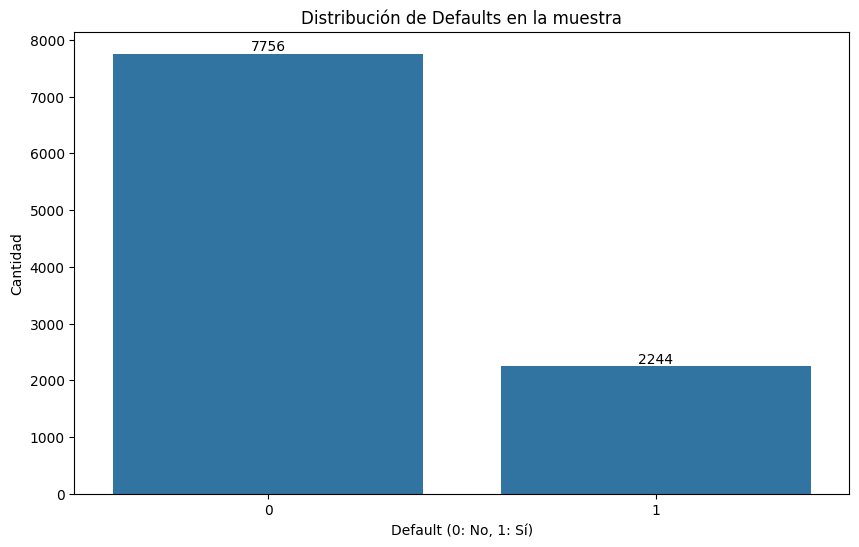


=== Resumen del Preprocesamiento ===
Dimensiones de X: (10000, 24)

Distribución de clases:
default.payment.next.month
0    0.776
1    0.224
Name: proportion, dtype: float64

Estadísticas de algunas variables numéricas:
             ID  LIMIT_BAL       SEX  EDUCATION  MARRIAGE       AGE     PAY_0  \
count  10000.00   10000.00  10000.00   10000.00  10000.00  10000.00  10000.00   
mean    5051.03      -0.00      0.58       0.81      0.58      0.00      1.88   
std     2961.31       1.00      0.49       0.73      0.52      1.00      1.28   
min        1.00      -1.20      0.00       0.00      0.00     -1.54      0.00   
25%     2500.75      -0.89      0.00       0.00      0.00     -0.79      1.00   

          PAY_2     PAY_3    PAY_4  ...  BILL_AMT3  BILL_AMT4  BILL_AMT5  \
count  10000.00  10000.00  10000.0  ...   10000.00   10000.00   10000.00   
mean       1.76      1.76      1.7  ...       0.00       0.00      -0.00   
std        1.30      1.31      1.2  ...       1.00       1.00   

In [28]:
# Importamos las librerías necesarias
import pandas as pd
from datasets import load_dataset
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Cargamos el dataset y lo mezclamos
dataset = load_dataset("scikit-learn/credit-card-clients", streaming=True)
df = pd.DataFrame(list(dataset['train'].shuffle(seed=42).take(10000)))

# 1. Examinamos la información básica del DataFrame
print("\n=== Información del DataFrame ===")
print(df.info())

# 2. Verificamos los tipos de datos y valores únicos para cada columna
print("\n=== Valores únicos por columna ===")
for column in df.columns:
    print(f"\n{column}:")
    print(f"Tipo de dato: {df[column].dtype}")
    print(f"Valores únicos: {df[column].nunique()}")
    print(f"Primeros valores únicos: {sorted(df[column].unique())[:5]}")

# 3. Verificamos valores nulos
print("\n=== Valores nulos ===")
print(df.isnull().sum())

# 4. Estadísticas descriptivas básicas
print("\n=== Estadísticas descriptivas ===")
print(df.describe())

# 5. Debalance de clases

print("📊 Distribución de la variable objetivo (default.payment.next.month):")
class_dist = df['default.payment.next.month'].value_counts(normalize=True)
print("\nPorcentajes:")
for clase, porcentaje in class_dist.items():
    print(f"Clase {clase}: {porcentaje*100:.2f}%")

# Visualizamos la distribución con un gráfico de barras
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='default.payment.next.month')
plt.title('Distribución de Defaults en la muestra')
plt.xlabel('Default (0: No, 1: Sí)')
plt.ylabel('Cantidad')

# Añadimos los valores exactos sobre cada barra
for i in plt.gca().containers[0]:
    plt.text(i.get_x() + i.get_width()/2,
            i.get_height(),
            f'{int(i.get_height())}',
            ha='center', va='bottom')

plt.show()

# Funciones de Preprocesamiento de datos

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder

def categorize_features(df):
    """
    Separa las características en numéricas y categóricas.
    """
    # Variables numéricas (montos y edad)
    numeric_features = [
        'LIMIT_BAL', 'AGE',
        'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
        'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'
    ]

    # Variables categóricas
    categorical_features = [
        'SEX', 'EDUCATION', 'MARRIAGE',
        'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'
    ]

    return numeric_features, categorical_features

def clean_categorical_data(df):
    """
    Limpia y corrige valores en variables categóricas.
    """
    df = df.copy()

    # Corregir valores en EDUCATION
    # 0, 5 y 6 son valores no definidos, los convertimos a 4 (Others)
    df['EDUCATION'] = df['EDUCATION'].replace([0, 5, 6], 4)

    # Corregir valores en MARRIAGE
    # 0 es un valor no definido, lo convertimos a 3 (Others)
    df['MARRIAGE'] = df['MARRIAGE'].replace([0], 3)

    return df

def preprocess_data(df):
    """
    Realiza el preprocesamiento completo de los datos.
    """
    # 1. Separar features
    numeric_features, categorical_features = categorize_features(df)

    # 2. Limpiar datos categóricos
    df = clean_categorical_data(df)

    # 3. Estandarizar variables numéricas
    scaler = StandardScaler()
    df[numeric_features] = scaler.fit_transform(df[numeric_features])

    # 4. Codificar variables categóricas
    label_encoders = {}
    for feature in categorical_features:
        label_encoders[feature] = LabelEncoder()
        df[feature] = label_encoders[feature].fit_transform(df[feature].astype(str))

    # 5. Separar features y target
    X = df.drop('default.payment.next.month', axis=1)
    y = df['default.payment.next.month']

    # 6. Guardar información del preprocesamiento
    preprocessing_info = {
        'numeric_features': numeric_features,
        'categorical_features': categorical_features,
        'scaler': scaler,
        'label_encoders': label_encoders
    }

    return X, y, preprocessing_info

def print_preprocessing_summary(X, y):
    """
    Imprime un resumen del preprocesamiento.
    """
    print("\n=== Resumen del Preprocesamiento ===")
    print(f"Dimensiones de X: {X.shape}")

    print("\nDistribución de clases:")
    print(pd.Series(y).value_counts(normalize=True).round(3))

    print("\nEstadísticas de algunas variables numéricas:")
    print(X.describe().round(2).head())

    # Ejecutar el Preprocesamiento

# Importar y cargar datos
from datasets import load_dataset
import pandas as pd

# 1. Cargar datos
dataset = load_dataset("scikit-learn/credit-card-clients", streaming=True)
df = pd.DataFrame(list(dataset['train'].shuffle(seed=42).take(10000)))

# 2. Aplicar preprocesamiento
X, y, preprocessing_info = preprocess_data(df)

# 3. Imprimir resumen
print_preprocessing_summary(X, y)

# 4. Verificar las características procesadas
print("\n=== Características procesadas ===")
print("\nCaracterísticas numéricas:")
print(preprocessing_info['numeric_features'])
print("\nCaracterísticas categóricas:")
print(preprocessing_info['categorical_features'])

# 5. Mostrar información adicional sobre los datos procesados
print("\n=== Información adicional ===")
print(f"Número total de características: {X.shape[1]}")
print(f"Número total de observaciones: {X.shape[0]}")
print("\nPrimeras columnas del dataset procesado:")
print(X.head())

##Preparación para el entrenamiento

In [91]:
# --- PREPARACIÓN PARA EL ENTRENAMIENTO ---

# Importamos las bibliotecas necesarias
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
import xgboost as xgb
import numpy as np
import pandas as pd

# Fijamos la semilla aleatoria para garantizar reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# División estratificada de datos (80% entrenamiento, 20% prueba)
# stratify=y asegura que la proporción de las clases se mantenga
X_train, X_test, y_train, y_test = train_test_split(
    X,              # Matriz de características
    y,              # Vector objetivo (default/no default)
    test_size=0.2,  # 20% para prueba
    random_state=RANDOM_STATE,
    stratify=y      # Mantiene proporción de clases
)

# Para XGBoost, necesitamos un conjunto de validación
X_train_xgb, X_val_xgb, y_train_xgb, y_val_xgb = train_test_split(
    X_train, y_train,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_train
)

# Definición de los modelos a entrenar
models = {

    # Random Forest
    "RandomForest": RandomForestClassifier(
        n_estimators=100,       # Número de árboles en el bosque
        max_depth=None,         # Permite árboles profundos
        min_samples_leaf=5,     # Control básico de overfitting
        max_features='sqrt',    # Número de features a considerar en cada split
        n_jobs=-1,             # Usa todos los núcleos disponibles
        random_state=RANDOM_STATE
    ),

    # XGBoost
    "XGBoost": xgb.XGBClassifier(
        learning_rate=0.1,      # Tamaño de paso en cada iteración
        n_estimators=100,       # Número máximo de árboles
        max_depth=6,           # Profundidad fija para control de complejidad
        early_stopping_rounds=20,# Detiene el entrenamiento si no hay mejora en 20 rondas
        min_child_weight=1,     # Control de overfitting similar a min_samples_leaf
        subsample=0.8,          # Fracción de muestras para cada árbol
        colsample_bytree=0.8,   # Fracción de features para cada árbol
        eval_metric=['auc', 'error', 'logloss'],  # Múltiples métricas de evaluación
        random_state=RANDOM_STATE,
        enable_categorical=False # Deshabilitamos características categóricas
    ),

    # K-Nearest Neighbors (KNN)
    # La elección de k se basa en la raíz cuadrada del número de muestras
    "KNN": KNeighborsClassifier(
        n_neighbors=int(np.sqrt(len(X_train))),  # k basado en regla de la raíz
        weights='uniform',       # Todos los vecinos tienen el mismo peso
        metric='euclidean'      # Distancia euclidiana para similitud
    ),

    # Support Vector Machine (SVM)
    # Utilizamos kernel RBF para capturar relaciones no lineales
    "SVM": SVC(
        kernel='rbf',           # Tipo de kernel: 'linear', 'poly', 'rbf', 'sigmoid'
        C=1.0,                  # Parámetro de margen suave (soft margin):
                               # - C grande: margen más estrecho, menos errores permitidos
                               # - C pequeño: margen más amplio, más errores permitidos
        gamma='scale',          # Coeficiente γ para kernel RBF: exp(-γ||x₁ - x₂||²)
                               # 'scale' calcula γ = 1 / (n_features * X.var())
        random_state=RANDOM_STATE
    ),

    # PCA + KNN
    # Combinamos reducción de dimensionalidad con clasificación
    "PCA-KNN": {
        'pca': PCA(
            n_components=0.95,   # Mantener 95% de la varianza explicada
            random_state=RANDOM_STATE
        ),
        'knn': KNeighborsClassifier(
            n_neighbors=5,       # k inicial para clasificación
            weights='uniform',
            metric='euclidean'
        )
    }
}

# Diccionarios para almacenar resultados
predictions = {}      # Predicciones binarias (0/1)
probabilities = {}    # Probabilidades [0,1]
xgb_results = {}     # Para almacenar resultados de evaluación de XGBoost
components = {}      # Almacenará componentes principales para PCA

# Información sobre la división de datos
print("=== Información de la División de Datos ===")
print(f"Dimensiones de X_train: {X_train.shape}")
print(f"Dimensiones de X_test: {X_test.shape}")
print(f"Dimensiones de X_val_xgb (para XGBoost): {X_val_xgb.shape}")
print("\nDistribución de clases:")
print("\nConjunto de entrenamiento:")
print(pd.Series(y_train).value_counts(normalize=True).round(3))
print("\nConjunto de prueba:")
print(pd.Series(y_test).value_counts(normalize=True).round(3))
print("\nConjunto de validación XGBoost:")
print(pd.Series(y_val_xgb).value_counts(normalize=True).round(3))


=== Información de la División de Datos ===
Dimensiones de X_train: (480, 14)
Dimensiones de X_test: (120, 14)
Dimensiones de X_val_xgb (para XGBoost): (96, 14)

Distribución de clases:

Conjunto de entrenamiento:
Loan_Status
1    0.69
0    0.31
Name: proportion, dtype: float64

Conjunto de prueba:
Loan_Status
1    0.692
0    0.308
Name: proportion, dtype: float64

Conjunto de validación XGBoost:
Loan_Status
1    0.688
0    0.312
Name: proportion, dtype: float64


##Iniciar entrenamiento

In [92]:
# --- ENTRENAMIENTO DE MODELOS ---

def print_model_info(name, model, X_train):
    """
    Imprime información relevante según el tipo de modelo
    """
    print(f"\nInformación para {name}:")

    if hasattr(model, 'feature_importances_'):
        # Para modelos basados en árboles que tienen importancia de características
        importances = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': model.feature_importances_
        }).sort_values('Importance', ascending=False)

        print("\nTop 5 características más importantes:")
        print(importances.head())
        print("\nTop 5 características menos importantes:")
        print(importances.tail())

    # Información específica para cada tipo de modelo
    if name == "RandomForest":
        print(f"\nNúmero de árboles: {model.n_estimators}")
        print(f"Máxima profundidad: {model.max_depth if model.max_depth else 'No limitada'}")
        print(f"Features por split: {model.max_features}")
    elif name == "XGBoost":
        print("\nMejor iteración: ", model.best_iteration if hasattr(model, 'best_iteration') else None)
        print(f"Tasa de aprendizaje: {model.learning_rate}")
        print(f"Número de estimadores: {model.n_estimators}")
    elif name == "KNN":
        print(f"\nNúmero de vecinos (k): {model.n_neighbors}")
        print(f"Métrica de distancia: {model.metric}")
    elif name == "SVM":
        print(f"\nTipo de kernel: {model.kernel}")
        print(f"Parámetro C (regularización): {model.C}")
        print(f"Parámetro gamma: {model.gamma}")
    elif name == "PCA-KNN":
        print(f"\nNúmero de componentes principales: {model['pca'].n_components_}")
        print(f"Varianza explicada acumulada: {np.sum(model['pca'].explained_variance_ratio_):.2f}")
        print(f"Número de vecinos (k): {model['knn'].n_neighbors}")
        print(f"Métrica de distancia: {model['knn'].metric}")

# Iteramos sobre cada modelo para entrenamiento y predicciones
for name, model in models.items():
    print(f"\n=== Entrenando modelo: {name} ===")

    # Entrenamiento del modelo
    if name == "XGBoost":
        # Usamos los conjuntos de validación previamente creados
        model.fit(
            X_train_xgb, y_train_xgb,
            eval_set=[(X_train_xgb, y_train_xgb), (X_val_xgb, y_val_xgb)],
            verbose=False
        )

        predictions[name] = model.predict(X_test)
        probabilities[name] = model.predict_proba(X_test)[:, 1]
    elif name == "PCA-KNN":
        # Aplicamos PCA primero
        components[name] = model['pca'].fit_transform(X_train)
        model['knn'].fit(components[name], y_train)

        # Transformamos el conjunto de prueba con el PCA ajustado
        X_test_pca = model['pca'].transform(X_test)
        predictions[name] = model['knn'].predict(X_test_pca)
        probabilities[name] = model['knn'].predict_proba(X_test_pca)[:, 1]
    elif name == "SVM":
        # Configuramos probability=True para habilitar predict_proba
        model.set_params(probability=True)
        model.fit(X_train, y_train)
        predictions[name] = model.predict(X_test)
        probabilities[name] = model.predict_proba(X_test)[:, 1]
    else:
        # Para RandomForest y KNN
        model.fit(X_train, y_train)
        predictions[name] = model.predict(X_test)
        probabilities[name] = model.predict_proba(X_test)[:, 1]

    # Mostrar información del modelo
    print_model_info(name, model, X_train)

# Calculamos y mostramos el tiempo de ejecución promedio para predicciones
import time

print("\n=== Evaluación de Tiempo de Predicción ===")
for name, model in models.items():
    times = []
    for _ in range(100):  # 100 predicciones para promedio estable
        start_time = time.time()
        if name == "PCA-KNN":
            X_test_pca = model['pca'].transform(X_test[:100])
            model['knn'].predict(X_test_pca)
        else:
            model.predict(X_test[:100])
        times.append(time.time() - start_time)

    print(f"\n{name}:")
    print(f"Tiempo promedio de predicción: {np.mean(times)*1000:.2f} ms")
    print(f"Desviación estándar: {np.std(times)*1000:.2f} ms")


=== Entrenando modelo: RandomForest ===

Información para RandomForest:

Top 5 características más importantes:
             Feature  Importance
8     Credit_History    0.391958
4    ApplicantIncome    0.162289
6         LoanAmount    0.124670
5  CoapplicantIncome    0.109947
1         Dependents    0.037202

Top 5 características menos importantes:
             Feature  Importance
9              Rural    0.020876
7   Loan_Amount_Term    0.012044
13              Male    0.011070
3      Self_Employed    0.009812
12            Female    0.008923

Número de árboles: 100
Máxima profundidad: No limitada
Features por split: sqrt

=== Entrenando modelo: XGBoost ===

Información para XGBoost:

Top 5 características más importantes:
             Feature  Importance
8     Credit_History    0.405512
10         Semiurban    0.072829
2          Education    0.060767
7   Loan_Amount_Term    0.057159
0            Married    0.051523

Top 5 características menos importantes:
          Feature  Import

##MÉTRICAS DE EVALUACIÓN DE MODELOS DE RIESGO CREDITICIO

<ipython-input-94-e9091149a00d>:66: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_metrics[col] = pd.to_numeric(df_metrics[col], errors='ignore')



=== Tabla Comparativa de Métricas ===
      Modelo Accuracy Precision Recall F1-Score AUC-ROC
RandomForest   0.8500    0.8218 1.0000   0.9022  0.8069
     XGBoost   0.8167    0.8144 0.9518   0.8778  0.8072
         KNN   0.7417    0.7281 1.0000   0.8426  0.7273
         SVM   0.8417    0.8137 1.0000   0.8973  0.8349
     PCA-KNN   0.6917    0.7255 0.8916   0.8000  0.6291

=== Matrices de Confusión ===


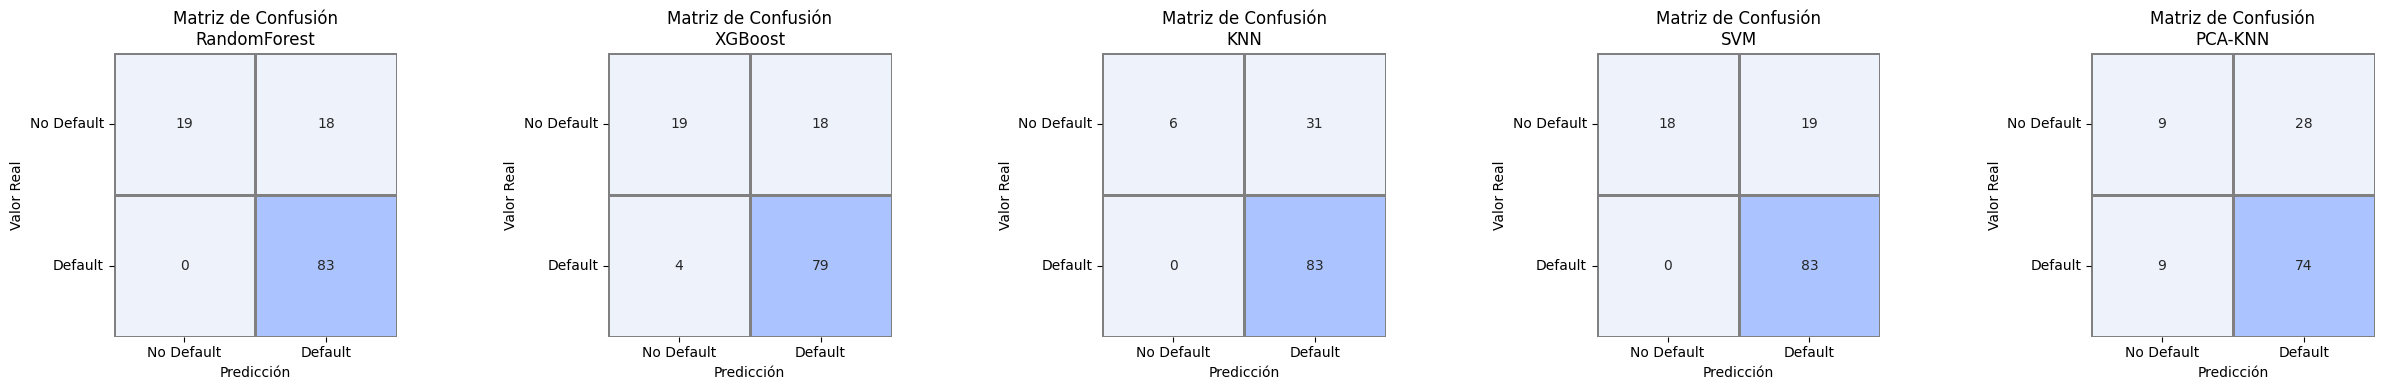


=== Curvas ROC ===


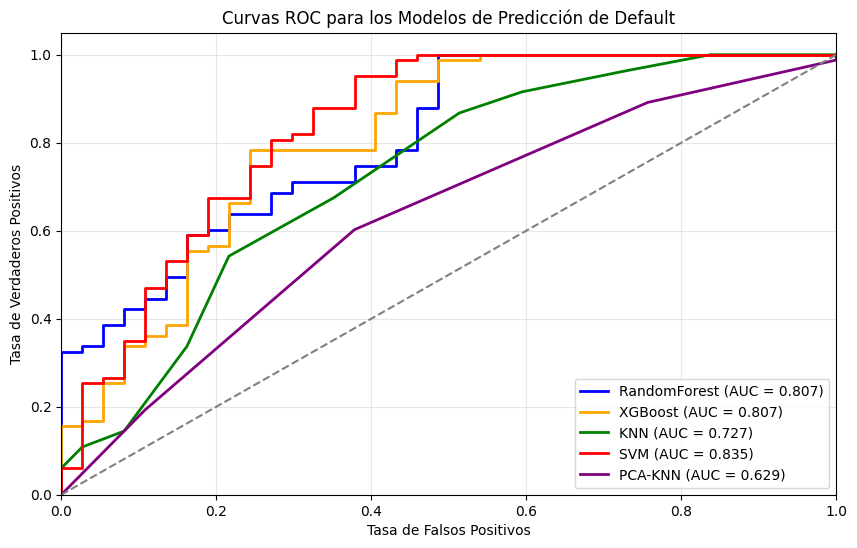

In [94]:
# --- Evaluación y Métricas Tradicionales ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score, roc_curve
)

class ModelEvaluator:
    def __init__(self, y_true, predictions, probabilities):
        """
        Inicializa el evaluador con los datos necesarios.

        Parámetros:
        -----------
        y_true: array-like
            Etiquetas verdaderas
        predictions: dict
            Diccionario con predicciones de cada modelo
        probabilities: dict
            Diccionario con probabilidades de cada modelo
        """
        # Asegurar que los datos estén en el formato correcto
        self.y_true = np.array(y_true)
        self.predictions = {k: np.array(v) for k, v in predictions.items()}
        self.probabilities = {k: np.array(v) for k, v in probabilities.items()}
        self.colors = ["#EDF2FB", "#ABC4FF"]

    def create_metrics_table(self):
        """
        Crea una tabla comparativa con las métricas de todos los modelos.
        """
        metrics = []
        for name, pred in self.predictions.items():
            try:
                metric_dict = {
                    'Modelo': name,
                    'Accuracy': accuracy_score(self.y_true, pred),
                    'Precision': precision_score(self.y_true, pred, zero_division=0),
                    'Recall': recall_score(self.y_true, pred),
                    'F1-Score': f1_score(self.y_true, pred),
                    'AUC-ROC': roc_auc_score(self.y_true, self.probabilities[name])
                }
            except Exception as e:
                print(f"Error calculando métricas para {name}: {str(e)}")
                metric_dict = {
                    'Modelo': name,
                    'Accuracy': 'Error',
                    'Precision': 'Error',
                    'Recall': 'Error',
                    'F1-Score': 'Error',
                    'AUC-ROC': 'Error'
                }

            metrics.append(metric_dict)

        df_metrics = pd.DataFrame(metrics)

        # Formatear las columnas numéricas
        numeric_columns = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']

        for col in numeric_columns:
            if col in df_metrics.columns:
                df_metrics[col] = pd.to_numeric(df_metrics[col], errors='ignore')
                df_metrics[col] = df_metrics[col].apply(
                    lambda x: f"{x:.4f}" if isinstance(x, (int, float)) else x
                )

        return df_metrics

    def plot_confusion_matrices(self):
        """
        Visualiza las matrices de confusión para modelos de clasificación.
        """
        n_models = len(self.predictions)
        fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 4))
        if n_models == 1:
            axes = [axes]

        cmap = sns.color_palette(self.colors, as_cmap=True)

        for idx, (name, y_pred) in enumerate(self.predictions.items()):
            try:
                cm = confusion_matrix(self.y_true, y_pred)
                sns.heatmap(
                    cm,
                    annot=True,
                    fmt='d',
                    ax=axes[idx],
                    cmap=cmap,
                    cbar=False,
                    linewidths=1,
                    linecolor='gray',
                    square=True
                )
                axes[idx].set_title(f'Matriz de Confusión\n{name}')
                axes[idx].set_xlabel('Predicción')
                axes[idx].set_ylabel('Valor Real')
                axes[idx].set_xticklabels(['No Default', 'Default'])
                axes[idx].set_yticklabels(['No Default', 'Default'], rotation=0)
            except Exception as e:
                print(f"Error al crear matriz de confusión para {name}: {str(e)}")

        plt.tight_layout()
        return fig

    def plot_roc_curves(self):
        """
        Visualiza las curvas ROC para modelos de clasificación.
        """
        fig, ax = plt.subplots(figsize=(10, 6))
        colors = ['blue', 'orange', 'green', 'red', 'purple']  # Añadir más colores si es necesario

        for (name, probs), color in zip(self.probabilities.items(), colors):
            try:
                fpr, tpr, _ = roc_curve(self.y_true, probs)
                auc = roc_auc_score(self.y_true, probs)
                ax.plot(fpr, tpr, color=color, lw=2,
                       label=f'{name} (AUC = {auc:.3f})')
            except Exception as e:
                print(f"Error al crear curva ROC para {name}: {str(e)}")

        ax.plot([0, 1], [0, 1], color='gray', linestyle='--')
        ax.set(xlim=[0.0, 1.0], ylim=[0.0, 1.05],
               xlabel='Tasa de Falsos Positivos',
               ylabel='Tasa de Verdaderos Positivos',
               title='Curvas ROC para los Modelos de Predicción de Default')
        ax.legend(loc="lower right")
        ax.grid(True, alpha=0.3)

        return fig

    def evaluate_all(self):
        """
        Ejecuta todas las evaluaciones y muestra los resultados.
        """
        # Tabla de métricas
        try:
            metrics_table = self.create_metrics_table()
            print("\n=== Tabla Comparativa de Métricas ===")
            print(metrics_table.to_string(index=False))
        except Exception as e:
            print(f"Error al crear tabla de métricas: {str(e)}")

        # Matrices de confusión
        print("\n=== Matrices de Confusión ===")
        cm_fig = self.plot_confusion_matrices()
        if cm_fig:
            plt.show()

        # Curvas ROC
        print("\n=== Curvas ROC ===")
        roc_fig = self.plot_roc_curves()
        if roc_fig:
            plt.show()

def evaluar_modelos(y_test, predictions, probabilities):
    """
    Función auxiliar para ejecutar la evaluación simplificada de modelos.

    Parámetros:
    -----------
    y_test : array-like
        Etiquetas verdaderas
    predictions : dict
        Diccionario con predicciones de cada modelo
    probabilities : dict
        Diccionario con probabilidades de cada modelo
    """
    evaluator = ModelEvaluator(y_test, predictions, probabilities)
    evaluator.evaluate_all()

# Ejemplo de uso:
evaluar_modelos(y_test, predictions, probabilities)

##Métricas de Evaluación Avanzadas

=== Análisis de Entropía para Modelos de Clasificación ===

Entropía media para RandomForest: 0.5480

Entropía media para XGBoost: 0.5132

Entropía media para KNN: 0.5069

Entropía media para SVM: 0.5124

Entropía media para PCA-KNN: 0.4961


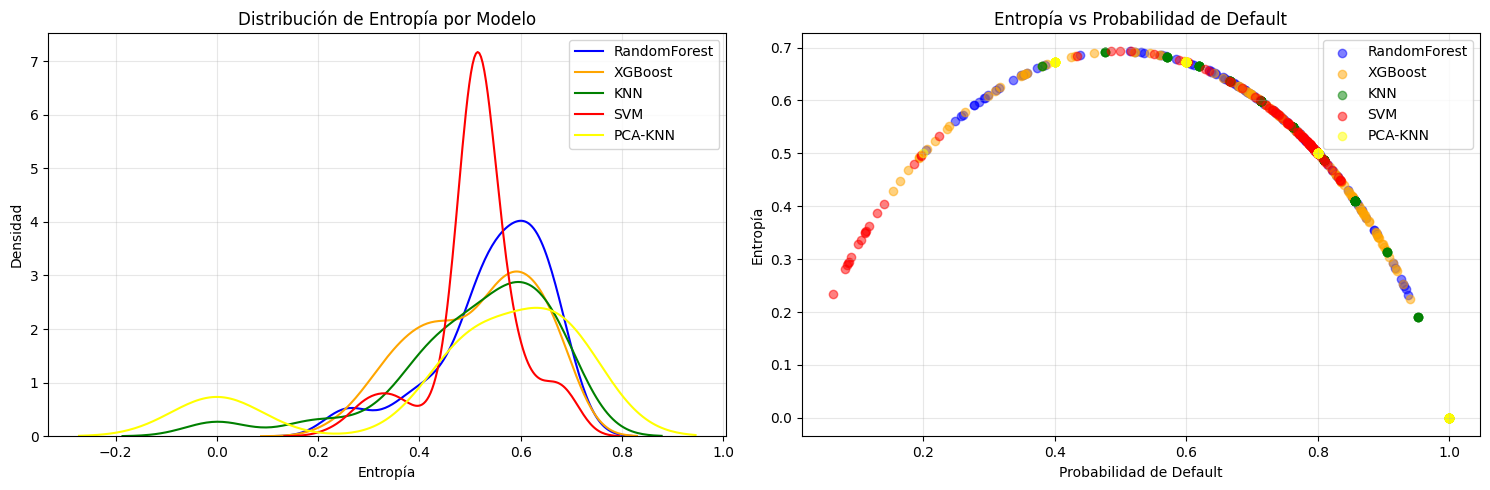


Entropía media por clase real:

RandomForest:
Clase 0 (No Default): 0.5962
Clase 1 (Default): 0.5265

XGBoost:
Clase 0 (No Default): 0.5552
Clase 1 (Default): 0.4945

KNN:
Clase 0 (No Default): 0.5789
Clase 1 (Default): 0.4748

SVM:
Clase 0 (No Default): 0.4703
Clase 1 (Default): 0.5312

PCA-KNN:
Clase 0 (No Default): 0.5536
Clase 1 (Default): 0.4705


In [95]:
# --- Análisis de Entropía para Modelos de Clasificación ---

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy

def calculate_entropy(probabilities):
    """
    Calcula la entropía de las predicciones para clasificación binaria.

    Parámetros:
    -----------
    probabilities: array-like
        Array de probabilidades de la clase positiva (default)

    Retorna:
    --------
    array-like
        Valores de entropía para cada predicción
    """
    # Convertir a probabilidades de ambas clases
    p = np.vstack([1 - probabilities, probabilities]).T
    return entropy(p, axis=1)

def analyze_entropy(y_true, probabilities):
    """
    Analiza y visualiza la entropía de las predicciones de los modelos de clasificación.

    Parámetros:
    -----------
    y_true: array-like
        Etiquetas verdaderas
    probabilities: dict
        Diccionario con las probabilidades predichas por cada modelo
    """
    # Calcular entropía para cada modelo
    entropy_dict = {}
    mean_entropy_dict = {}

    # Verificar que hay modelos para analizar
    if not probabilities:
        print("No hay modelos para analizar la entropía.")
        return

    for name, probs in probabilities.items():
        try:
            entropy_vals = calculate_entropy(probs)
            entropy_dict[name] = entropy_vals
            mean_entropy_dict[name] = np.mean(entropy_vals)
            print(f"\nEntropía media para {name}: {mean_entropy_dict[name]:.4f}")
        except Exception as e:
            print(f"Error calculando entropía para {name}: {str(e)}")
            continue

    # Crear subplot con dos gráficas
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # 1. Distribución de entropía
    colors = ['blue', 'orange', 'green', 'red', 'yellow']
    for (name, entropy_vals), color in zip(entropy_dict.items(), colors):
        sns.kdeplot(data=entropy_vals, label=name, ax=ax1, color=color)
    ax1.set_title('Distribución de Entropía por Modelo')
    ax1.set_xlabel('Entropía')
    ax1.set_ylabel('Densidad')
    ax1.legend()
    ax1.grid(True, alpha=0.3)


    # 2. Entropía vs Probabilidad predicha
    for (name, entropy_vals), color in zip(entropy_dict.items(), colors):
        ax2.scatter(probabilities[name], entropy_vals,
                   alpha=0.5, label=name, color=color)
    ax2.set_title('Entropía vs Probabilidad de Default')
    ax2.set_xlabel('Probabilidad de Default')
    ax2.set_ylabel('Entropía')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Análisis adicional: Entropía por clase real
    print("\nEntropía media por clase real:")
    for name, entropy_vals in entropy_dict.items():
        print(f"\n{name}:")
        for clase in [0, 1]:
            mask = y_true == clase
            mean_entropy = np.mean(entropy_vals[mask])
            print(f"Clase {clase} ({'No Default' if clase == 0 else 'Default'}): {mean_entropy:.4f}")

# Ejecutar el análisis
print("=== Análisis de Entropía para Modelos de Clasificación ===")
analyze_entropy(y_test, probabilities)